# Точки интереса (points of interest)

25-26 строки - пример добавления своего фильтра в обработку изображения. Фильтр Харриса (https://en.wikipedia.org/wiki/Harris_Corner_Detector) возвращает очень маленькие значения, нужно придумать, как их визуализировать и подобрать параметры фильтра, чтобы он находил небольшое количество наиболее значимых точек интереса (https://www.cs.utah.edu/~srikumar/cv_spring2017_files/Keypoints&Descriptors.pdf, https://stackoverflow.com/questions/29133085/what-are-keypoints-in-image-processing).

Для ускорения вычислений размер картинки уменьшается в 3 раза по каждому измерению, с этим можно экспериментировать. UPD: поставил downscale_factor=1, все равно норм по fps.

Можно или визуализировать результаты работы фильтра после окончания обработки (после 33 строки), или переписать функцию, передаваемую в custom_operation, чтобы она модифицировала входное изображение. Пример работы второго варианта на фотокарточке в следующей клетке - белые области на футболках - это как раз выделенные точки интереса.

P.S. Под некоторыми операционными системами окно не закрывается, если выполнение программы завершилось по нажатию кнопки q. Мы не знаем, как это исправить и оч извиняемся

P.P.S. Получилось с помощью фильтра Харриса найти границы объектов - 2 балла, получилось найти точки интереса - 3 балла.

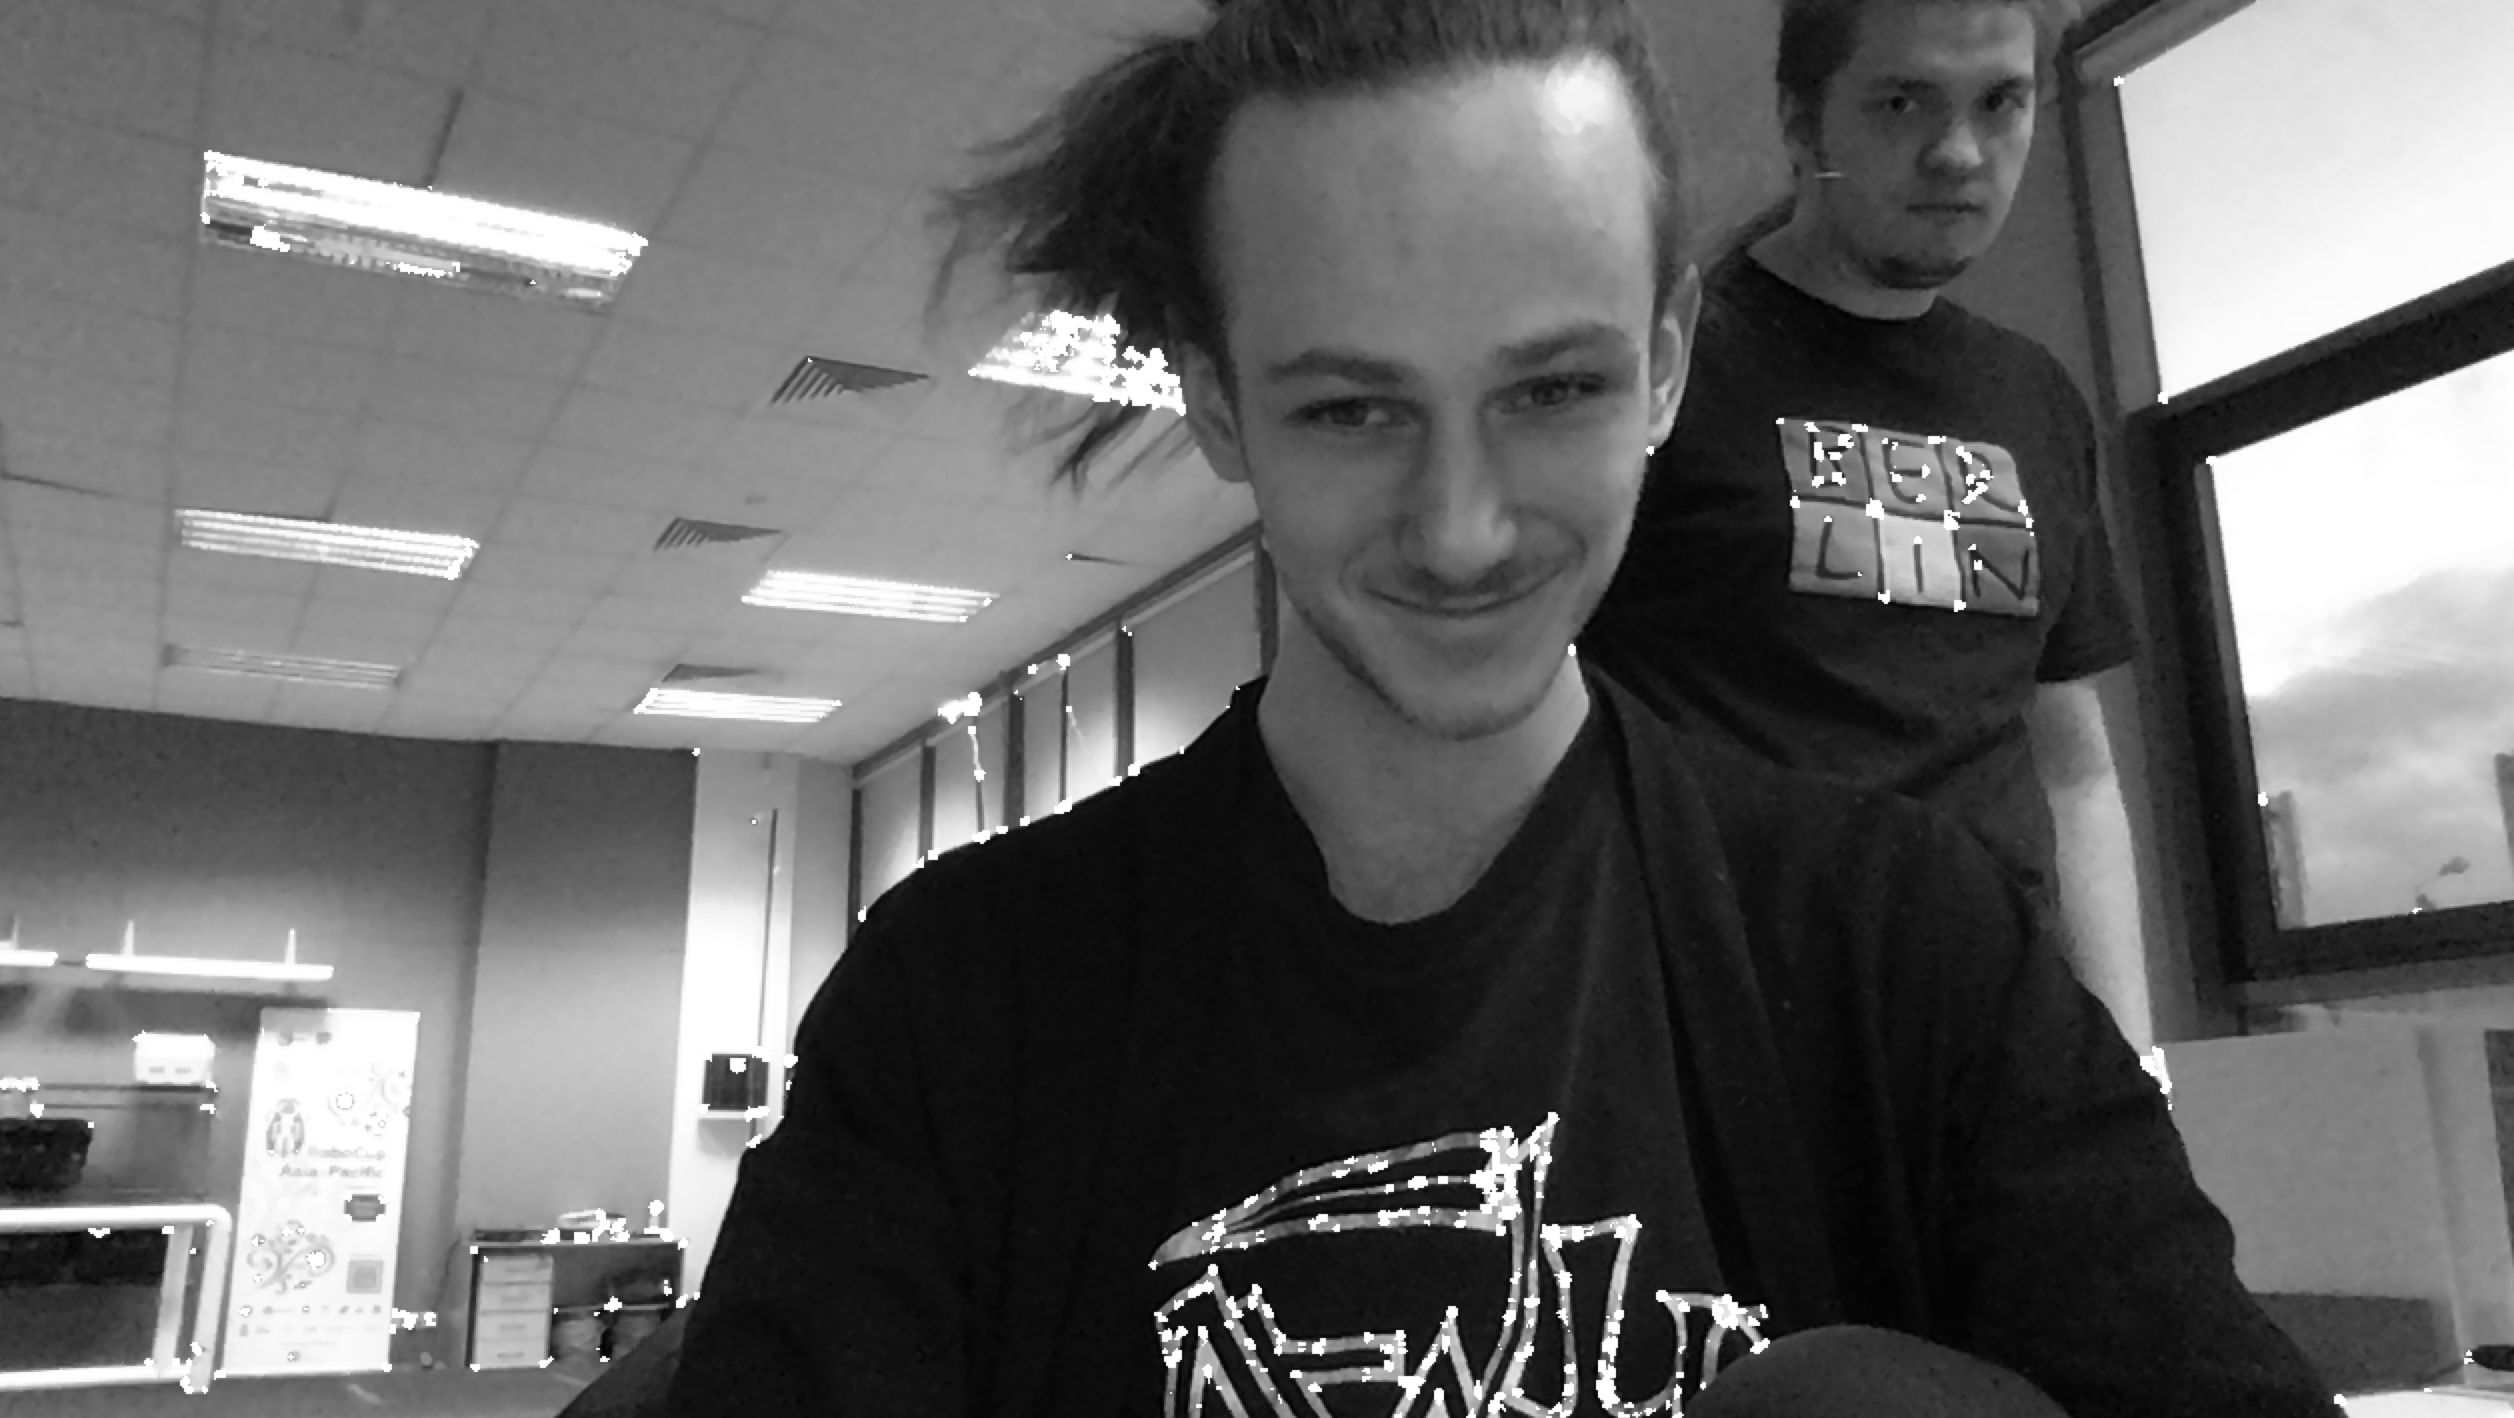

In [80]:
import cv2
import time
import os
import math
import sys

sys.path.append("../modules/")

import input_output
import processor

det = processor.Processors ()
det.add_processor ("keypoints extr")

det.add_filter (processor.resize (downscale_factor_ = 1),
                
                "keypoints extr", "downscale")
det.add_filter (processor.colorspace_to_colorspace ("RGB", "GRAY"),
                "keypoints extr", "colorspaces change")

bsz = 3 #block size
asz = 5 #aperture size
k   = 0.001 #alg parameter

det.add_filter (processor.custom_operation (lambda img : cv2.cornerHarris
    (img, bsz, asz, k) * 5000, "harris filter"), "keypoints extr", "harris filter")

source  = input_output.Source ("-1")

while (True):
    frame = source.get_frame ()

    result, success = det.process (frame, "keypoints extr")

    cv2.imshow ("harris", result)
    
    time.sleep (0.02)

    keyb = cv2.waitKey (1) & 0xFF

    if (keyb == ord('q')):
        break

source.release ()
cv2.waitKey (1)
cv2.destroyAllWindows ()

In [16]:
import cv2
import time
import os
import math
import sys

sys.path.append("../modules/")

import input_output
import processor

det = processor.Processors ()
det.add_processor ("keypoints extr")

det.add_filter (processor.resize (downscale_factor_ = 1),
                
                "keypoints extr", "downscale")
det.add_filter (processor.colorspace_to_colorspace ("RGB", "GRAY"),
                "keypoints extr", "colorspaces change")

bsz = 11 #block size
asz = 7 #aperture size
k   = 0.1 #alg parameter

det.add_filter (processor.custom_operation (lambda img : cv2.cornerHarris
    (img, bsz, asz, k) * 50, "harris filter"), "keypoints extr", "harris filter")

source  = input_output.Source ("-1")

while (True):
    frame = source.get_frame ()

    result, success = det.process (frame, "keypoints extr")

    cv2.imshow ("harris", result)
    
    time.sleep (0.02)

    keyb = cv2.waitKey (1) & 0xFF

    if (keyb == ord('q')):
        break

source.release ()
cv2.waitKey (1)
cv2.destroyAllWindows ()

In [61]:
source.release ()

# Фильтрация и выделение руки

Напишите настраиваемый детектор, который сможет стабильно выделять любой объект (как баскетбольное кольцо на семинаре), это может быть рука, цветной стикер, чашка, помпон шапки. Для этого нужно:

1) Cкопировать вторую демку из семинара

2) Создать шесть трекбаров (по примеру трекбара для параметра гамма-коррекции), которые будут соответствовать верхним и нижним порогам при получении маски объекта 

3) Добавить обработку связных компонент фильтрами filter_connected_components и morphology, подобрать параметры фильтрации так, чтобы весь процесс работал стабильно. Реализация этих фильтров находится в файле processor.py в папке modules, там можно посмотреть, как создавать эти фильтры

Второй пункт - 3 балла, 3 пункт - 2 балла

In [83]:
import cv2
import time
import os
import math
import sys

sys.path.append("../modules/")

import input_output
import processor

low_H = 0
low_S = 0
low_V = 0
high_H = 255
high_S = 255
high_V = 255

def on_lh(val):
    global low_H
    global high_H
    low_H = val
    low_H = min(high_H-1, low_H)
    cv2.setTrackbarPos("low_h", "trackbars", low_H)
    det.processors ["basket"] ["inrange rgb"].set_ths((low_H, low_S, low_V), (high_H, high_S, high_V))
def on_hh(val):
    global high_H
    global low_H
    high_H = val
    high_H = max(high_H, low_H+1)
    cv2.setTrackbarPos("high_h", "trackbars", high_H)    
    det.processors ["basket"] ["inrange rgb"].set_ths((low_H, low_S, low_V), (high_H, high_S, high_V))
def on_ls(val):
    global low_S
    global high_S
    low_S = val
    low_S = min(high_S-1, low_S)
    cv2.setTrackbarPos("low_s", "trackbars", low_S)
    det.processors ["basket"] ["inrange rgb"].set_ths((low_H, low_S, low_V), (high_H, high_S, high_V))
def on_hs(val):
    global high_S
    global low_S
    high_S = val
    high_S = max(high_S, low_S+1)
    cv2.setTrackbarPos("high_s", "trackbars", high_S)
    det.processors ["basket"] ["inrange rgb"].set_ths((low_H, low_S, low_V), (high_H, high_S, high_V))
def on_lv(val):
    global low_V
    global high_V
    low_V = val
    low_V = min(high_V-1, low_V)
    cv2.setTrackbarPos("low_v", "trackbars", low_V)
    det.processors ["basket"] ["inrange rgb"].set_ths((low_H, low_S, low_V), (high_H, high_S, high_V))
def on_hv(val):
    global high_V
    global low_V
    high_V = val
    high_V = max(high_V, low_V+1)
    cv2.setTrackbarPos("high_v", "trackbars", high_V)
    det.processors ["basket"] ["inrange rgb"].set_ths((low_H, low_S, low_V), (high_H, high_S, high_V))


det = processor.Processors ()
det.add_processor ("basket")

#gamma correction (lighting conditions change simulation) and online tuning
det.add_filter (processor.gamma_correction (1), "basket", "gamma correction")

cv2.namedWindow ('trackbars')
cv2.createTrackbar ("gamma", "trackbars", 100, 200, 
    lambda new_coeff : det.processors ["basket"] ["gamma correction"].set_gamma (float (new_coeff) / 100))

low_th  = (35, 15, 50)
high_th = (60, 75, 135)

det.add_filter (processor.inrange (low_th, high_th), "basket", "inrange rgb")

cv2.createTrackbar("low_h", "trackbars" , 0, 254, on_lh)
cv2.createTrackbar("high_h", "trackbars" , 1, 255, on_hh)
cv2.createTrackbar("low_s", "trackbars" , 0, 254, on_ls)
cv2.createTrackbar("high_s", "trackbars" , 1, 255, on_hs)
cv2.createTrackbar("low_v", "trackbars" , 0, 254, on_lv)
cv2.createTrackbar("high_v", "trackbars" , 1, 255, on_hv)


#bbox extraction
det.add_filter (processor.max_area_cc_bbox (), "basket", "bbox extraction")

source = input_output.Source ("../data/images/rgb_basket.jpg")
#source  = input_output.Source ("../data/output.avi")
#source  = input_output.Source ("-1")

while (True):
    frame = source.get_frame ()

    mask, success = det.process (frame, "basket")

    stages = det.get_stages_picts ("basket")

    #for i in range (len (stages) - 1): #ебаный рот этого казино!
    #    cv2.imshow (str (i), stages [i])
    cv2.imshow ("basket", input_output.form_grid(stages[:3], window_x_sz=1400)) #спасибо деду за победу
        
    time.sleep (0.02)

    keyb = cv2.waitKey (1) & 0xFF

    if (keyb == ord('q')):
        break

source.release()
cv2.destroyAllWindows()

In [1]:
import cv2
import time
import os
import math
import sys

sys.path.append("../modules/")

import input_output
import processor

low_H = 0
low_S = 0
low_V = 0
ek = 11
ek0 = 5
dk = 5
ok = 5
ck = 7
high_H = 255
high_S = 255
high_V = 255
areal = 100
areah = 50000
heil = 200
heih = 500
widl = 200
widh = 500
denl = -1
denh = -1
cells = 8

def on_lh(val):
    global low_H
    global high_H
    low_H = val
    low_H = min(high_H-1, low_H)
    cv2.setTrackbarPos("low_h", "trackbars", low_H)
    det.processors ["basket"] ["inrange rgb"].set_ths((low_H, low_S, low_V), (high_H, high_S, high_V))
def on_hh(val):
    global high_H
    global low_H
    high_H = val
    high_H = max(high_H, low_H+1)
    cv2.setTrackbarPos("high_h", "trackbars", high_H)    
    det.processors ["basket"] ["inrange rgb"].set_ths((low_H, low_S, low_V), (high_H, high_S, high_V))
def on_ls(val):
    global low_S
    global high_S
    low_S = val
    low_S = min(high_S-1, low_S)
    cv2.setTrackbarPos("low_s", "trackbars", low_S)
    det.processors ["basket"] ["inrange rgb"].set_ths((low_H, low_S, low_V), (high_H, high_S, high_V))
def on_hs(val):
    global high_S
    global low_S
    high_S = val
    high_S = max(high_S, low_S+1)
    cv2.setTrackbarPos("high_s", "trackbars", high_S)
    det.processors ["basket"] ["inrange rgb"].set_ths((low_H, low_S, low_V), (high_H, high_S, high_V))
def on_lv(val):
    global low_V
    global high_V
    low_V = val
    low_V = min(high_V-1, low_V)
    cv2.setTrackbarPos("low_v", "trackbars", low_V)
    det.processors ["basket"] ["inrange rgb"].set_ths((low_H, low_S, low_V), (high_H, high_S, high_V))
def on_hv(val):
    global high_V
    global low_V
    high_V = val
    high_V = max(high_V, low_V+1)
    cv2.setTrackbarPos("high_v", "trackbars", high_V)
    det.processors ["basket"] ["inrange rgb"].set_ths((low_H, low_S, low_V), (high_H, high_S, high_V))
def on_erode(val1, val2):
    global ek
    global numeroe
#    cv2.setTrackbarPos("erode", "trackbars", ek)
def on_dilate(val1, val2):
    global dk
    global numerod
 #   cv2.setTrackbarPos("dilate", "trackbars", dk)
    


det = processor.Processors ()
det.add_processor ("basket")

#gamma correction (lighting conditions change simulation) and online tuning

#det.add_filter (processor.gamma_correction (1), "basket", "gamma correction")

cv2.namedWindow ('trackbars')
#cv2.createTrackbar ("gamma", "trackbars", 100, 200, 
#    lambda new_coeff : det.processors ["basket"] ["gamma correction"].set_gamma (float (new_coeff) / 100))

low_th  = (35, 15, 50)
high_th = (60, 75, 135)

det.add_filter (processor.inrange (low_th, high_th), "basket", "inrange rgb")

cv2.createTrackbar("low_h", "trackbars" , 0, 254, on_lh)
cv2.createTrackbar("high_h", "trackbars" , 1, 255, on_hh)
cv2.createTrackbar("low_s", "trackbars" , 0, 254, on_ls)
cv2.createTrackbar("high_s", "trackbars" , 1, 255, on_hs)
cv2.createTrackbar("low_v", "trackbars" , 0, 254, on_lv)
cv2.createTrackbar("high_v", "trackbars" , 1, 255, on_hv)

det.add_filter (processor.morphology ("erode", ek0), "basket", "erode0")
det.add_filter (processor.morphology ("dilate", dk), "basket", "dilate1")
det.add_filter (processor.morphology ("close", ck), "basket", "close1")
det.add_filter (processor.morphology ("erode", ek), "basket", "erode1")


#det.add_filter (processor.morphology ("open", ek), "basket", "open")
#det.add_filter (processor.morphology ("close", dk), "basket", "close")

#cv2.createButton("erode", on_erode)
#cv2.createButton("dilate", on_dilate)

det.add_filter (processor.filter_connected_components 
                (areal, areah, heil, heih, widl, widh, denl, denh), "basket", "kavo?")
#bbox extraction
det.add_filter (processor.max_area_cc_bbox (), "basket", "bbox extraction")

#source = input_output.Source ("../data/images/rgb_basket.jpg")
#source  = input_output.Source ("../data/output.avi")
source  = input_output.Source ("-1")

while (True):
    frame = source.get_frame ()

    mask, success = det.process (frame, "basket")

    stages = det.get_stages_picts ("basket")

    #for i in range (len (stages) - 1): #ебаный рот этого казино!
    #    cv2.imshow (str (i), stages [i])
    cv2.imshow ("basket", input_output.form_grid(stages[:cells], window_x_sz=1400)) #спасибо деду за победу
        
    time.sleep (0.02)

    keyb = cv2.waitKey (1) & 0xFF

    if (keyb == ord('q')):
        break

source.release()
cv2.destroyAllWindows()

In [2]:
cv2.destroyAllWindows()